<H3>Accumulated Local Effects (ALE)</H3>
<p>ALE is an alternative of PDP and it fixes the problem PDP has, which is inaccuracy when target feature is correlated to another feature in model input.</p>

In [1]:
import warnings
warnings.filterwarnings('ignore')
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from lib.process_data import process_bike



Bad key "text.kerning_factor" on line 4 in
e:\Projects\Envs\Repo\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [78]:
from importlib import reload
reload_flg = True
if reload_flg:
    from lib import ml_helper
    reload(ml_helper)
    from lib.ml_helper import *
else:
    from lib.ml_helper import *

In [2]:
# set up plotting theme and configurations
# plt.style.available # to find all the style available to matplotlib
plt.style.use('ggplot')

<h3>Loading bike data and regression model</h3>

In [3]:
# loading bike data
cols_df, bike_df = process_bike("./data/bike.csv")
feature_cols = cols_df.loc[cols_df.input.isin(['num']),'cols'].to_list()
resp = 'cnt'
X = bike_df[feature_cols].to_numpy()
y = bike_df[resp].to_numpy()

convert yr to string


In [4]:
# loading bike model and fetching predicted value along with bike_df
lasso_model = pickle.load(open("./model/bike_lasso.sav",'rb'))
gradient_tree_model = pickle.load(open("./model/bike_boost_tree.sav",'rb'))
outcome_df = pd.DataFrame(data=np.hstack([X
    , y.reshape(-1,1)
    , lasso_model.predict(X).reshape(-1,1)
    , gradient_tree_model.predict(X).reshape(-1,1)
]), columns = feature_cols + ['actual','lasso_pred', 'gbt_pred'])
outcome_df.head(5)

,temp,hum,windspeed,days_since_2011,season_encoded,yr_encoded,mnth_encoded,holiday_encoded,weekday_encoded,workingday_encoded,weathersit_encoded,actual,lasso_pred,gbt_pred
0,8.175849,80.5833,10.749882,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,985.0,1302.340894,1205.215691
1,9.083466,69.6087,16.652113,1.0,3.0,0.0,0.0,0.0,6.0,0.0,0.0,801.0,1346.367326,1527.731160
2,1.229108,43.7273,16.636703,2.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1349.0,1203.845992,1266.543447
3,1.400000,59.0435,10.739832,3.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,1562.0,1172.281448,1452.411320
4,2.666979,43.6957,12.522300,4.0,3.0,0.0,0.0,0.0,2.0,1.0,1.0,1600.0,1607.003516,1645.921447


In [5]:
# loading the encode map
encode_map = {'season':['SPRING','SUMMER','FALL','WINTER']
        , 'yr':['2011','2012']
        , 'mnth':['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
        , 'holiday':['NO HOLIDAY','HOLIDAY']
        , 'weekday':['MON','TUE','WED','THU','FRI','SAT','SUN']
        , 'workingday':['NO WORKING DAY','WORKING DAY']
        , 'weathersit':['MISTY','GOOD','RAIN/SNOW/STORM']
    }

In [6]:
# lasso's coef table
feature_df = pd.DataFrame(np.hstack([
    np.array(feature_cols).reshape(-1,1)\
    , lasso_model.coef_.reshape(-1,1)])\
    , columns=['features','coef'])
feature_df

,features,coef
0,temp,107.23115878096603
1,hum,-25.896402703428233
2,windspeed,-57.9913661447737
3,days_since_2011,4.924194584100834
4,season_encoded,-281.0821979534998
5,yr_encoded,197.73937386253644
6,mnth_encoded,-44.529472625157084
7,holiday_encoded,-547.2552873132154
8,weekday_encoded,-0.14680794847795178
9,workingday_encoded,107.81567428731715


<h3>Partial Dependency Plot Issue</h3>
<p>In the section let's explore the relationship between windspeed and humidity</p>
<p>Say windspeed is our feature to explain.</p>
<ul>
<li>Our assumption is that humidity distribution will be the same at any point of windspeed.</li>
<li>However, We can see that humidity distribution is very different from the its distribution of windspeed at 25km/h. It means that we can't apply windspeed as 25 at high humidity scenario. Let's pause and think about it. When windspeed is high, from our experience, it would be a cool dry day. Certainly humidity wouldn't be high.</li>
<li>Hence, using PDP for windspeed won't work perfectly given their negative correlation. <u>More specifically, we're averaging on instances don't exist in the dataset.</u></li>
</ul>

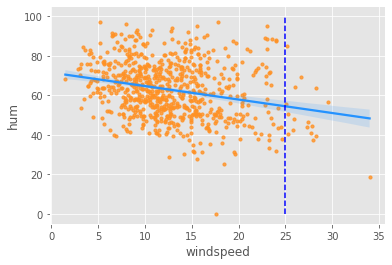

In [7]:
g = sns.regplot(x = 'windspeed', y='hum', data = bike_df, fit_reg=True
    , scatter_kws={"color": "#ff9124", 's':10}, line_kws={"color": "#2492ff"})
g.plot(np.ones(10) * 25, np.linspace(0,100,num=10), "--", color="blue")
plt.show()

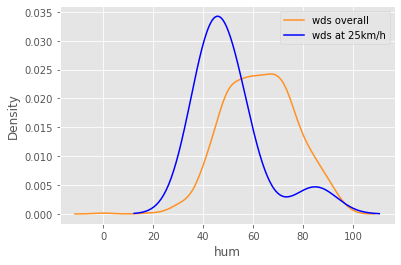

In [8]:
# to demonstrate humidity distribution varies at different points of windspeed
# this chart also solves the problem of plotting two seaborn charts in one figure.
#
wds_gap = 1
f, ax1 = plt.subplots(figsize=(6,4))
sns.kdeplot(data = bike_df, x = 'hum', ax=ax1, color="#ff9124", label='wds overall')
sns.kdeplot(data = bike_df[(bike_df['windspeed'] >= (25 - wds_gap)) & (bike_df['windspeed'] <= (25 + wds_gap))]['hum']\
    , ax=ax1, color = "blue", label="wds at 25km/h")
ax1.legend(loc="best")
plt.show()

<h5>Marginal Plot (M-Plot)</h5>
<p>one possible solution to resolve this issue is via M-Plot. For example, if we want to know the impact of windspeed at 25km/h, we only average the predicted value by only taking P(humidity|windspeed=25). Same for any other values of windspeed.</p>
<p>However, our goal is to find the impact Windspeed itself. We already know humidity and windspeed going hand in hand. Hence, we want to isolate the mixed impact from other features like humidity.</p>
<p>M-plot is not an ideal solution</p>

<h5>Accumulated Local Effect</h5>
<p>If we recall the issue of PDP and M-Plot. It's 1) non-existance of data instance and 2) correlated / mixed impact on the feature that needs to explain on.</p>
<p>If we want to explain impact of windspeed at 25km/h, what we can do to cancel our the humidity mixed impact on final prediction?</p>
<ol>
    <li>One way is to create a small window around wind speed say from 24km/h to 26km/h. Our assumption is that the humidity dist won't change much from 24km/h to 26km/h. And to be fair, we always can create a window small enough so that it doesn't change the local distribution of humidity.</li>
    <li>Then we calculate the averaged difference between value of upper bound (windspeed at 26km/h), say Ph and lower bound (windspeed at 24km/h), say Pl</li>
    <li>In this way, we cancel out the impact from humidity.</li>
</ol>
<p>Reference and support</p>
<ul>
    <li><a href="https://arxiv.org/abs/1612.08468">ALE original paper</a></li>
    <li><a href="https://docs.seldon.io/projects/alibi/en/stable/methods/ALE.html">Python library that supports ALE calculation - Alibi</a></li>
</ul>

##### Accumulated Local Effect Formula and Understanding (based on original paper)   
$f_{1,ale} = \int_{x_{min,1}}^{x_1} \int p_{2|1} (x_2|z_1)f^1(z_1,x_2)dx_2dz_1 - constant$  
where $f^1(x_1,x_2) \equiv \frac{\partial f(x_1,x_2)}{\partial x_1}$ represents the local effect of $x_1$ on $f(.)$ at $(x_1,x_2)$ and $x_{min,1}$ is the lowest value of $x_1$  
1. $f^1(x_1,x_2) \equiv \frac{\partial f(x_1,x_2)}{\partial x_1}$, just understand as the $\frac{f(x_1 + \Delta,x_2) - f(x_1,x_2)}{\Delta}$, in which $\Delta$ is very small; hence, we can see it's a difference between $x_1 + \Delta$ and $x_1$ under a small window
2. the formula does two things. The integral along $x_2$ to find the local effect at say $x_1 = p$ and let's imagine we have infinite tiny windows along $x_1$, and we need to calculate local effect for all those windows. Then, we conduct another integral along $x_1$ to find total accumulated local effect. 
3. General form of Uncentered ALE Main Effect (1st Order),  
$g_{j,ALE}(x_j) \equiv \lim_{K\to\infty} \sum_{k=1}^{k_{j}^{K}(x_j)} E[f(z_{k,j}^K, X_{\setminus j}) - f(z_{k-1,j}^K, X_{\setminus j})|X_j \in (z_{k-1,j}^K, z_{k,j}^{K})]$  
we noticed that the expectation is on the difference between upper bound and lower bound of $x_j$ around some value
4. Numerical Estimation of ALE (1st order)  
step1 (uncentered) - $\hat g_{j,ALE}(x) = \sum_{k=1}^{k_j(x)} \frac{1}{n_j(k)} \sum_{i:x_{i,j} \in N_j(k)} [f(z_{k,j},X_{i, \setminus j}) - f(z_{k-1,j},X_{i, \setminus j})]$  
step2 (centered) - $\hat f_{j, ALE}(x) = \hat g_{j,ALE}(x) - \frac{1}{n} \sum_{i=1}^{n} \hat g_{j,ALE}(x_{i,j}) = \hat g_{j,ALE}(x) - \frac{1}{n} \sum_{k=1}^{K} n_j(k)\hat g_{j,ALE}(z_{k,j})$

<h3>Implement Accumulated Local Effect</h3>
<ol>
    <li>based on its estimation formula in the paper. We wrote our version of ALE at 1st order</li>
    <li>We also will implement an Alibi version to validate our calculation</li>
</ol>
<p>Reference</p>
<ul>
<li><a href="https://github.com/SeldonIO/alibi/blob/master/doc/source/methods/ALE.ipynb">Alibi ALE effect</a></li>
</ul>

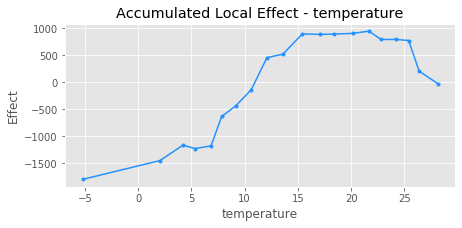

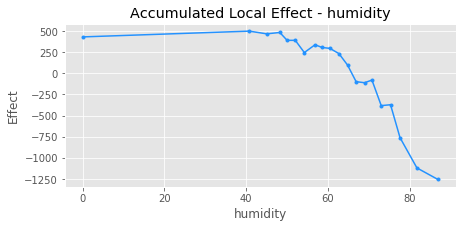

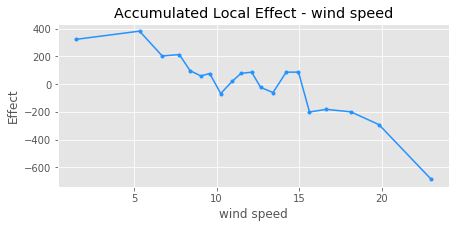

In [85]:
from lib.ml_helper import *
# plotting variables for bike data
blueprint = {'temperature':0, 'humidity':1, 'wind speed':2}
for k,v in blueprint.items():
    g=plot_ale(estimator = gradient_tree_model, X = X, var_idx = v, var_name = k, n_split=20)
    g.show()

In [75]:
# experiment the method of Anova using linear regression
# same as what machine learning book plotted.
